# THE MARCENKO–PASTUR (MP) PDF


Assymptotic distribution of eigenvalues of a specific random matrix. https://en.wikipedia.org/wiki/Marchenko%E2%80%93Pastur_distribution

 The code above shows how well MP pdf explains eigenvalues of random matrix x

In [74]:
import matplotlib.pyplot as plt
import numpy as np,pandas as pd

from sklearn.neighbors import KernelDensity
from scipy.optimize import minimize
from scipy.linalg import block_diag
from sklearn.covariance import LedoitWolf

import cvxpy as cp

In [75]:
def mpPDF(var,q,pts):
    # Marcenko-Pastur pdf
    # q=T/N (>1)
    # pts - amount of points
    eMin,eMax=var*(1-(1./q)**.5)**2,var*(1+(1./q)**.5)**2
    eVal=np.linspace(eMin,eMax,pts)
    pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
    pdf=pd.Series(pdf,index=eVal)
    return pdf

In [76]:

def getPCA(matrix):
# Get eVal,eVec from a !!!Hermitian matrix (cov matrix is a hermitian matrix)
    eVal,eVec=np.linalg.eigh(matrix) 
    indices=eVal.argsort()[::-1] # arguments for sorting eVal desc
    eVal,eVec=eVal[indices],eVec[:,indices]
    eVal=np.diagflat(eVal)
    return eVal,eVec


def fitKDE(obs,bWidth=.25,kernel='gaussian',x=None):
    # Fit kernel to a series of obs, and derive the prob of obs
    # x is the array of values on which the fit KDE will be evaluated
    if len(obs.shape)==1:obs=obs.reshape(-1,1)
    kde=KernelDensity(kernel=kernel,bandwidth=bWidth).fit(obs)
    if x is None:x=np.unique(obs).reshape(-1,1)
    if len(x.shape)==1:x=x.reshape(-1,1)
    logProb=kde.score_samples(x) # log(density)
    pdf=pd.Series(np.exp(logProb),index=x.flatten())
    return pdf

In [108]:
np.random.seed(32)

N = 250#1000  # num of vars #N = 250, T = 3000, nFacts = 50 -> Not bad
T = 500#10000 # num of observations
tmp_nFact = 50
x = np.random.normal(0, 1, size = (T, N))
cor = np.corrcoef(x, rowvar=0) # cor.shape = (1000,1000). If rowvar=1 - row represents a var, with observations in the columns.
eVal0 , eVec0 = getPCA( cor ) 
pdf0 = mpPDF(1., q=x.shape[0]/float(x.shape[1]), pts=N)
pdf1 = fitKDE(np.diag(eVal0), bWidth=.09) #empirical pdf


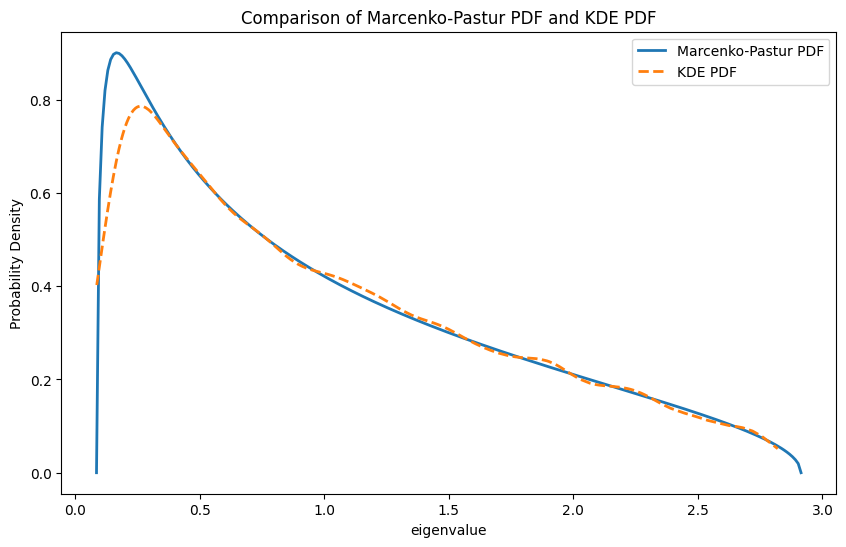

In [109]:
plt.figure(figsize=(10, 6))
plt.plot(pdf0.keys(), pdf0, label='Marcenko-Pastur PDF', linewidth=2)
plt.plot(pdf1.keys(), pdf1, label='KDE PDF', linestyle='--', linewidth=2)
plt.title('Comparison of Marcenko-Pastur PDF and KDE PDF')
plt.xlabel('eigenvalue')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

# MP for not perfectly random function

The code above shows how MP works with not perfectly random function.

_____
Look at RANDOM MATRIX THEORY AND FINANCIAL CORRELATIONS LAURENT LALOUX, PIERRE CIZEAU and MARC POTTERS to understand the approach

In [110]:
def getRndCov(nCols, nFacts): #nFacts - contains signal out of nCols
    w = np.random.normal(size=(nCols, nFacts))
    cov = np.dot(w, w.T) #random cov matrix, however not full rank
    cov += np.diag(np.random.uniform(size=nCols)) #full rank cov
    return cov

def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std = np.sqrt(np.diag(cov))
    corr = cov/np.outer(std,std)
    corr[corr<-1], corr[corr>1] = -1,1 #for numerical errors
    return corr
    
def corr2cov(corr, std):
    cov = corr * np.outer(std, std)
    return cov     
    
#snippet 2.4 - fitting the marcenko-pastur pdf - find variance
#Fit error
def errPDFs(var, eVal, q, bWidth, pts=1000):
    var = var[0]
    pdf0 = mpPDF(var, q, pts) #theoretical pdf
    pdf1 = fitKDE(eVal, bWidth, x=pdf0.index.values) #empirical pdf
    sse = np.sum((pdf1-pdf0)**2)
    print("sse:"+str(sse))
    return sse 
    
# find max random eVal by fitting Marcenko's dist
# and return variance
def findMaxEval(eVal, q, bWidth):
    out = minimize(lambda *x: errPDFs(*x), x0=np.array(0.5), args=(eVal, q, bWidth), bounds=((1E-5, 1-1E-5),))
    print("found errPDFs"+str(out['x'][0]))
    if out['success']: var = out['x'][0]
    else: var=1
    eMax = var*(1+(1./q)**.5)**2
    return eMax, var

(array([0.75097065, 0.88751077, 0.88751077, 0.88751077, 0.75097065,
        0.68270059, 0.81924071, 0.61443053, 0.61443053, 0.47789041,
        0.61443053, 0.54616047, 0.40962036, 0.54616047, 0.47789041,
        0.3413503 , 0.47789041, 0.40962036, 0.3413503 , 0.3413503 ,
        0.40962036, 0.20481018, 0.40962036, 0.20481018, 0.27308024,
        0.3413503 , 0.20481018, 0.27308024, 0.20481018, 0.27308024,
        0.20481018, 0.20481018, 0.13654012, 0.20481018, 0.13654012,
        0.13654012, 0.13654012, 0.13654012, 0.20481018, 0.06827006,
        0.06827006, 0.06827006, 0.06827006, 0.06827006, 0.06827006,
        0.13654012, 0.06827006, 0.06827006, 0.06827006, 0.13654012]),
 array([0.10833584, 0.16692668, 0.22551751, 0.28410835, 0.34269919,
        0.40129003, 0.45988087, 0.5184717 , 0.57706254, 0.63565338,
        0.69424422, 0.75283506, 0.8114259 , 0.87001673, 0.92860757,
        0.98719841, 1.04578925, 1.10438009, 1.16297093, 1.22156176,
        1.2801526 , 1.33874344, 1.39733428, 1.

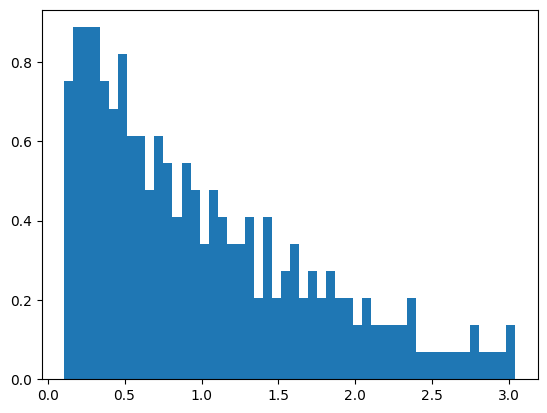

In [111]:
np.random.seed(32)

alpha, nCols, nFact, q = .995, N, tmp_nFact, T // N
pdf0 = mpPDF(1., q=x.shape[0]/float(x.shape[1]), pts=N)
cov = np.cov(np.random.normal(size=(nCols*q, nCols)), rowvar=0) #size = (1000*10,1000)
cov = alpha*cov+(1-alpha)*getRndCov(nCols, nFact) # noise + signal
corr0 = cov2corr(cov)
eVal01, eVec01 = getPCA(corr0)
#pdf2 = fitKDE(np.diag(eVal01), bWidth=.15) #empirical pdf

    # Figure 2.1 Plot empirical:KDE and Marcenko-Pastur, and histogram
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.hist(np.diag(eVal01), density = True, bins=50) # Histogram the eigenvalues

In [112]:
# find expected max eigenvalue and variance that maximizes the distance
eMax0, var0 = findMaxEval(np.diag(eVal01), q, bWidth=.01)

sse:195.33339775420106
sse:195.33338282381357
sse:9.300226494288626
sse:9.300226748421345
found errPDFs0.99999


**The fitted distribution implies that σ² ≈ 0.6768, indicating that only about 32.32% of the variance is signal. This is one way of measuring the signal-to-noise ratio in financial data sets, which is known to be low as a result of arbitrage forces.**


In [113]:
var0

0.99999

In [114]:
# calculate the number of factors (nFacts0) that have eigenvalues greater than a specified threshold (eMax0)nFacts0 = eVal01.shape[0]-np.diag(eVal01)[::-1].searchsorted(eMax0)
nFacts0 = eVal01.shape[0]-np.diag(eVal01)[::-1].searchsorted(eMax0)




In [115]:
nFacts0

3

In [116]:
len(eVal01)

250

In [117]:
pdf0 = mpPDF(var0, q=x.shape[0]/float(x.shape[1]), pts=N)

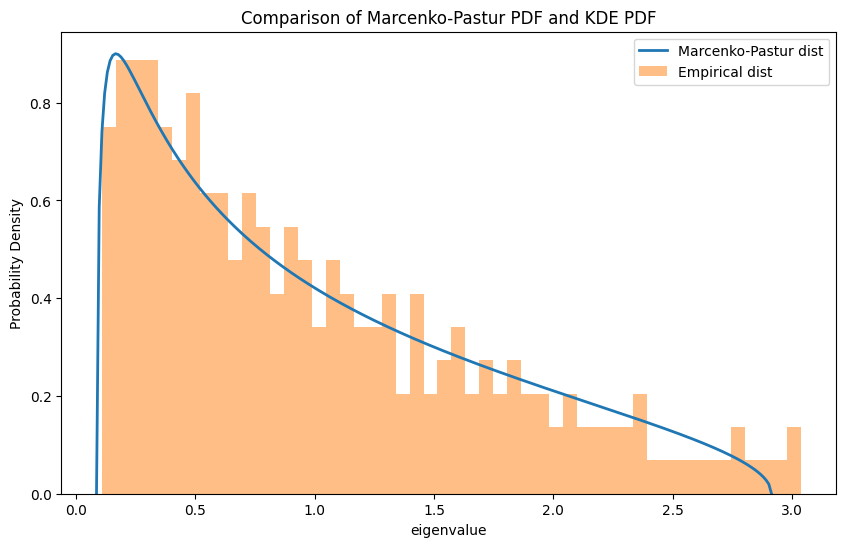

In [118]:
plt.figure(figsize=(10, 6))
plt.plot(pdf0.keys(), pdf0, label='Marcenko-Pastur dist', linewidth=2)
plt.hist(np.diag(eVal01), bins=50, density=True, alpha=0.5, label='Empirical dist')

#plt.plot(pdf1.keys(), pdf1, label='KDE PDF', linestyle='--', linewidth=2)
plt.title('Comparison of Marcenko-Pastur PDF and KDE PDF')
plt.xlabel('eigenvalue')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

In [88]:
eVal01

array([[2.16163449, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.10075199, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 2.00991001, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.37465185, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.36132376,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.3366593 ]])

In [89]:
# replace in random eigenvalues by constants
def denoisedCorr(eVal, eVec, nFacts):
    eVal_ = np.diag(eVal).copy()
    eVal_[nFacts:] = eVal_[nFacts:].sum()/float(eVal_.shape[0] - nFacts) #all but 0..i values equals (1/N-i)sum(eVal_[i..N]))
    eVal_ = np.diag(eVal_) #square matrix with eigenvalues as diagonal: eVal_.I
    corr1 = np.dot(eVec, eVal_).dot(eVec.T) #Eigendecomposition of a symmetric matrix: S = QΛQT
    corr1 = cov2corr(corr1) # Rescaling the correlation matrix to have 1s on the main diagonal
    return corr1

In [90]:
corr1=denoisedCorr(eVal01,eVec01,nFacts0)
eVal1,eVec1=getPCA(corr1)

In [91]:
findMaxEval(np.diag(eVal01), q, bWidth=.01)

sse:720.2738610058836
sse:720.2738031781555
sse:34.484156395827526
sse:34.48415572807776
sse:34.508829731324575
sse:34.50882922638969
sse:34.406850647717484
sse:34.40685064543443
sse:34.40684961320347
sse:34.406849612923835
sse:34.40684959734332
sse:34.40684959734364
found errPDFs0.9976325855169224


(2.089468813734191, 0.9976325855169224)

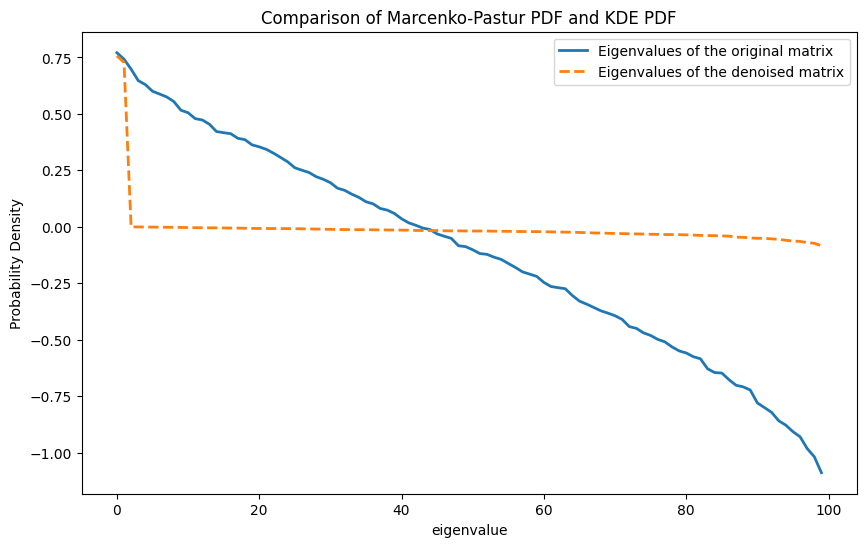

In [92]:
plt.figure(figsize=(10, 6))
plt.plot(range(N), np.log(np.diag(eVal01)), label='Eigenvalues of the original matrix', linewidth=2)
plt.plot(range(N), np.log(np.diag(eVal1)),  label='Eigenvalues of the denoised matrix', linewidth=2, linestyle='--')
#plt.hist(np.diag(eVal01), bins=50, density=True, alpha=0.5, label='Empirical dist')

#plt.plot(pdf1.keys(), pdf1, label='KDE PDF', linestyle='--', linewidth=2)
plt.title('Comparison of Marcenko-Pastur PDF and KDE PDF')
plt.xlabel('eigenvalue')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

In [93]:
#Generate a block-diagnoal covariance matrix and a vector of means
# Block represent sector
# bSize  number of assets in the sector
# bCorr correlation between assets in the sector
def formBlockMatrix(nBlocks, bSize, bCorr):
    block = np.ones( (bSize, bSize))*bCorr
    block[range(bSize), range(bSize)] = 1 #diagonal is 1
    corr = block_diag(*([block]*nBlocks))
    return corr



def formTrueMatrix(nBlocks, bSize, bCorr):
    corr0 = formBlockMatrix(nBlocks, bSize, bCorr)
    corr0 = pd.DataFrame(corr0)
    cols = corr0.columns.tolist()
    np.random.shuffle(cols)
    corr0 = corr0[cols].loc[cols].copy(deep=True)
    std0 = np.random.uniform(.05, .2, corr0.shape[0])
    cov0 = corr2cov(corr0, std0)
    mu0 = np.random.normal(std0, std0, cov0.shape[0]).reshape(-1,1)
    return mu0, cov0

nBlocks, bSize, bCorr=10,50,.5
np.random.seed(0)
mu0, cov0 = formTrueMatrix(nBlocks, bSize, bCorr)

In [94]:
def corr2cov(corr, std):
    cov = corr * np.outer(std, std)
    return cov

# Denoising of the empirical covariance matrix
# by constant residual eigenvalue method
def deNoiseCov(cov0,q,bWidth):
    corr0=cov2corr(cov0)
    eVal0,eVec0=getPCA(corr0)
    eMax0,var0=findMaxEval(np.diag(eVal0),q,bWidth)
    nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)
    corr1=denoisedCorr(eVal0,eVec0,nFacts0)
    cov1=corr2cov(corr1,np.diag(cov0)**.5)
    return cov1


# function to obtain empirical from true matrix with and without shrink
def simCovMu(mu0,cov0,nObs,shrink=False):
    x=np.random.multivariate_normal(mu0.flatten(),cov0,size=nObs)
    mu1=x.mean(axis=0).reshape(-1,1)
    if shrink:cov1=LedoitWolf().fit(x).covariance_
    else:cov1=np.cov(x,rowvar=0)
    return mu1,cov1

In [95]:
formBlockMatrix(3, 2, 0.5)

array([[1. , 0.5, 0. , 0. , 0. , 0. ],
       [0.5, 1. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 1. , 0.5, 0. , 0. ],
       [0. , 0. , 0.5, 1. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 1. , 0.5],
       [0. , 0. , 0. , 0. , 0.5, 1. ]])

In [96]:
#Generate a block-diagnoal covariance matrix and a vector of means
# Block represent sector
# bSize  number of assets in the sector
# bCorr correlation between assets in the sector
def formBlockMatrix(nBlocks, bSize, bCorr):
    block = np.ones( (bSize, bSize))*bCorr
    block[range(bSize), range(bSize)] = 1 #diagonal is 1
    corr = block_diag(*([block]*nBlocks))
    return corr



def formTrueMatrix(nBlocks, bSize, bCorr):
    corr0 = formBlockMatrix(nBlocks, bSize, bCorr)
    corr0 = pd.DataFrame(corr0)
    cols = corr0.columns.tolist()
    np.random.shuffle(cols)
    corr0 = corr0[cols].loc[cols].copy(deep=True)
    std0 = np.random.uniform(.05, .2, corr0.shape[0])
    cov0 = corr2cov(corr0, std0)
    mu0 = np.random.normal(std0, std0, cov0.shape[0]).reshape(-1,1)
    return mu0, cov0

def corr2cov(corr, std):
    cov = corr * np.outer(std, std)
    return cov

# Denoising of the empirical covariance matrix
# by constant residual eigenvalue method
def deNoiseCov(cov0,q,bWidth):
    corr0=cov2corr(cov0)
    eVal0,eVec0=getPCA(corr0)
    eMax0,var0=findMaxEval(np.diag(eVal0),q,bWidth)
    nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)
    corr1=denoisedCorr(eVal0,eVec0,nFacts0)
    cov1=corr2cov(corr1,np.diag(cov0)**.5)
    return cov1


# function to obtain empirical from true matrix with and without shrink
def simCovMu(mu0,cov0,nObs,shrink=False):
    x=np.random.multivariate_normal(mu0.flatten(),cov0,size=nObs)
    mu1=x.mean(axis=0).reshape(-1,1)
    if shrink:cov1=LedoitWolf().fit(x).covariance_
    else:cov1=np.cov(x,rowvar=0)
    return mu1,cov1, x

# replace in random eigenvalues by constants
def denoisedCorr(eVal, eVec, nFacts):
    eVal_ = np.diag(eVal).copy()
    eVal_[nFacts:] = eVal_[nFacts:].sum()/float(eVal_.shape[0] - nFacts) #all but 0..i values equals (1/N-i)sum(eVal_[i..N]))
    eVal_ = np.diag(eVal_) #square matrix with eigenvalues as diagonal: eVal_.I
    corr1 = np.dot(eVec, eVal_).dot(eVec.T) #Eigendecomposition of a symmetric matrix: S = QΛQT
    corr1 = cov2corr(corr1) # Rescaling the correlation matrix to have 1s on the main diagonal
    return corr1


def getRndCov(nCols, nFacts): #nFacts - contains signal out of nCols
    w = np.random.normal(size=(nCols, nFacts))
    cov = np.dot(w, w.T) #random cov matrix, however not full rank
    cov += np.diag(np.random.uniform(size=nCols)) #full rank cov
    return cov

def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std = np.sqrt(np.diag(cov))
    corr = cov/np.outer(std,std)
    corr[corr<-1], corr[corr>1] = -1,1 #for numerical errors
    return corr
    
def corr2cov(corr, std):
    cov = corr * np.outer(std, std)
    return cov     
    
#snippet 2.4 - fitting the marcenko-pastur pdf - find variance
#Fit error
def errPDFs(var, eVal, q, bWidth, pts=1000):
    var = var[0]
    pdf0 = mpPDF(var, q, pts) #theoretical pdf
    pdf1 = fitKDE(eVal, bWidth, x=pdf0.index.values) #empirical pdf
    sse = np.sum((pdf1-pdf0)**2)
    print("sse:"+str(sse))
    return sse 
    
# find max random eVal by fitting Marcenko's dist
# and return variance
def findMaxEval(eVal, q, bWidth):
    out = minimize(lambda *x: errPDFs(*x), x0=np.array(0.5), args=(eVal, q, bWidth), bounds=((1E-5, 1-1E-5),))
    print("found errPDFs"+str(out['x'][0]))
    if out['success']: var = out['x'][0]
    else: var=1
    eMax = var*(1+(1./q)**.5)**2
    return eMax, var



def getPCA(matrix):
# Get eVal,eVec from a !!!Hermitian matrix (cov matrix is a hermitian matrix)
    eVal,eVec=np.linalg.eigh(matrix) 
    indices=eVal.argsort()[::-1] # arguments for sorting eVal desc
    eVal,eVec=eVal[indices],eVec[:,indices]
    eVal=np.diagflat(eVal)
    return eVal,eVec


def fitKDE(obs,bWidth=.25,kernel='gaussian',x=None):
    # Fit kernel to a series of obs, and derive the prob of obs
    # x is the array of values on which the fit KDE will be evaluated
    if len(obs.shape)==1:obs=obs.reshape(-1,1)
    kde=KernelDensity(kernel=kernel,bandwidth=bWidth).fit(obs)
    if x is None:x=np.unique(obs).reshape(-1,1)
    if len(x.shape)==1:x=x.reshape(-1,1)
    logProb=kde.score_samples(x) # log(density)
    pdf=pd.Series(np.exp(logProb),index=x.flatten())
    return pdf


def mpPDF(var,q,pts):
    # Marcenko-Pastur pdf
    # q=T/N (>1)
    # pts - amount of points
    eMin,eMax=var*(1-(1./q)**.5)**2,var*(1+(1./q)**.5)**2
    eVal=np.linspace(eMin,eMax,pts)
    pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
    pdf=pd.Series(pdf,index=eVal)
    return pdf


def getRndCov(nCols, nFacts): #nFacts - contains signal out of nCols
    w = np.random.normal(size=(nCols, nFacts))
    cov = np.dot(w, w.T) #random cov matrix, however not full rank
    cov += np.diag(np.random.uniform(size=nCols)) #full rank cov
    return cov

def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std = np.sqrt(np.diag(cov))
    corr = cov/np.outer(std,std)
    corr[corr<-1], corr[corr>1] = -1,1 #for numerical errors
    return corr
    
def corr2cov(corr, std):
    cov = corr * np.outer(std, std)
    return cov     
    
#snippet 2.4 - fitting the marcenko-pastur pdf - find variance
#Fit error
def errPDFs(var, eVal, q, bWidth, pts=1000):
    var = var[0]
    pdf0 = mpPDF(var, q, pts) #theoretical pdf
    pdf1 = fitKDE(eVal, bWidth, x=pdf0.index.values) #empirical pdf
    sse = np.sum((pdf1-pdf0)**2)
    print("sse:"+str(sse))
    return sse 
    
# find max random eVal by fitting Marcenko's dist
# and return variance
def findMaxEval(eVal, q, bWidth):
    out = minimize(lambda *x: errPDFs(*x), x0=np.array(0.5), args=(eVal, q, bWidth), bounds=((1E-5, 1-1E-5),))
    print("found errPDFs"+str(out['x'][0]))
    if out['success']: var = out['x'][0]
    else: var=1
    eMax = var*(1+(1./q)**.5)**2
    return eMax, var


# find min var portfolio
def optPort(cov,mu=None):
    inv=np.linalg.inv(cov)
    ones=np.ones(shape=(inv.shape[0],1))
    if mu is None:mu=ones
    w=np.dot(inv,mu)
    w/=np.dot(ones.T,w)
    return w




def minimize_portfolio_variance(cov_matrix):
    """
    Finds the portfolio weights that minimize the portfolio variance.
    
    :param cov_matrix: The covariance matrix of asset returns.
    :return: Optimal portfolio weights as a numpy array.
    """
    # Number of assets
    n = cov_matrix.shape[0]

    # Portfolio weights variables
    w = cp.Variable(n)

    # Portfolio variance
    port_variance = cp.quad_form(w, cov_matrix)

    # Objective Function: Minimize portfolio variance
    objective = cp.Minimize(port_variance)

    # Constraints: weights sum to 1, non-negativity
    constraints = [cp.sum(w) == 1]

    # Problem
    problem = cp.Problem(objective, constraints)
    
    # Solve the problem
    problem.solve()

    # Portfolio weights
    optimal_weights = w.value
    
    return optimal_weights


def transform_returns_to_Xy_tensors(returns, lookback, n_timesteps, horizon, gap):
    X_list, y_list = [], []

    for i in range(lookback, n_timesteps - horizon - gap + 1):
        X_list.append(returns[i - lookback: i, :])
        y_list.append(returns[i + gap: i + gap + horizon, :])

    X = np.stack(X_list, axis=0)[:, None, ...]
    y = np.stack(y_list, axis=0)[:, None, ...]
    
    return X, y

def X_to_tensor(X, loockback, i = None):
    
    
    if i:
        if i < loockback:
            raise ValueError("i must not be greater than lookback")
    else: i = -1
    # Parameters
    i = len(X) if i == -1 else i

    # Slicing X and reshaping
    X_slice = X[i - lookback: i, :]  # This is (40, 250)
    X_tensor = torch.tensor(X_slice).unsqueeze(0).unsqueeze(0)  # Adding two dimensions
    return torch.tensor(X_tensor, dtype=torch.float32)

# Experiment (portfolio with shorting)

In [97]:
# find min var portfolio
def optPort(cov,mu=None):
    inv=np.linalg.inv(cov)
    ones=np.ones(shape=(inv.shape[0],1))
    if mu is None:mu=ones
    w=np.dot(inv,mu)
    w/=np.dot(ones.T,w)
    return w

## Without shrinkage 

To test shrinkage effec tset shrink = True

In [98]:
np.random.seed(32)
# block is a sector with bSize assets
nBlocks, bSize, bCorr =5, 50, .5
np.random.seed(0)
mu0, cov0 = formTrueMatrix(nBlocks, bSize, bCorr)
Xs = []

nObs, nTrials, bWidth, shrink, minVarPortf = 500, 50, .01, False, True
w1 = pd.DataFrame(columns = range(cov0.shape[0]), index = range(nTrials), dtype=float)
w1_d = w1.copy(deep=True)
w1_n = w1.copy(deep=True)

covs1 = []
covs1_d = []
covs1_n = []
np.random.seed(0)
for i in range(nTrials):
    mu1, cov1, X = simCovMu(mu0, cov0, nObs, shrink = shrink)
    Xs.append(X)
    if minVarPortf: mu1 = None
    cov1_d = deNoiseCov(cov1, nObs*1./cov1.shape[1], bWidth)
    w1.loc[i] = minimize_portfolio_variance(cov1).flatten()   #optPort(cov1, mu1).flatten() # add column vector w as row in w1
    w1_d.loc[i] = minimize_portfolio_variance(cov1_d).flatten() #optPort(cov1_d, mu1).flatten() # np.sum(w1_d, axis=1) is vector of 1's. sum(np.sum(w1_d, axis=0)= nTrials
    # so minimum-variance-portfolio is 1./nTrials*(np.sum(w1_d, axis=0)) - but distribution not stationary
   # tensorX = X_to_tensor(X, lookback)
   # weights_n = network(tensorX)
   # w1_n.loc[i] = weights_n.detach().numpy().flatten()#network(tensorX)
    
    
    covs1.append(cov1)
    covs1_d.append(cov1_d)
    
min_var_port = 1./nTrials*(np.sum(w1_d, axis=0)) 
#code snippet 2.11
w0 = optPort(cov0, None if minVarPortf else mu0) # w0 true percentage asset allocation
w0 = np.repeat(w0.T, w1.shape[0], axis=0) 
rmsd = np.mean((w1-w0).values.flatten()**2)**.5     #RMSE not denoised
rmsd_d = np.mean((w1_d-w0).values.flatten()**2)**.5 #RMSE denoised
#rmsd_n = np.mean((w1_n-w0).values.flatten()**2)**.5 #
print("RMSE not denoised:"+str( rmsd))
print("RMSE denoised:"+str( rmsd_d))
#print("RMSE neural:"+str( rmsd_n)

sse:9.682950591596391
sse:9.682950568017368
sse:73.34010391482511
sse:73.34010347555804
sse:9.686965171953247
sse:9.686965241425394
sse:9.682443920868925
sse:9.682443920870789
sse:9.682443920866678
sse:9.682443920866683
found errPDFs0.5004304983728507
sse:10.078409283893105
sse:10.078410098551457
sse:1760477207838.6572
sse:1756961527819.12
sse:152.9065449173088
sse:152.90651936920466
sse:9.446585213279423
sse:9.446585249811331
sse:9.445596477285424
sse:9.445596470441902
sse:9.445560920181364
sse:9.445560920228708
sse:9.445560918500572
sse:9.445560918500627
found errPDFs0.48530920998079374
sse:8.419070521617314
sse:8.419069401185379
sse:65.70522210611199
sse:65.70522174147504
sse:10.921986471731252
sse:10.92198785494983
sse:7.549168127437403
sse:7.549168177571481
sse:7.546846504249313
sse:7.5468465158152505
sse:7.546717876055712
sse:7.546717875901532
sse:7.546717853211343
sse:7.546717853211824
sse:7.546717853211368
sse:7.546717853211348
sse:7.546717853211296
sse:7.54671785321163
found e

sse:9.545641419825479
sse:9.545640463646235
sse:68.10056256764638
sse:68.10056232820389
sse:11.441361512984475
sse:11.441362837464663
sse:8.847737480804302
sse:8.847737497203596
sse:8.847485149270483
sse:8.847485151818614
sse:8.84747893054095
sse:8.847478930532835
sse:8.847478930473718
sse:8.847478930473713
found errPDFs0.5154712355450671
sse:10.450805243378287
sse:10.450804186254018
sse:67.52058259844458
sse:67.52058248657741
sse:13.014282830702069
sse:13.014284308093249
sse:9.73955457708734
sse:9.739554615541298
sse:9.738281035402327
sse:9.738281043630261
sse:9.738220489573788
sse:9.738220489505661
sse:9.738220485396909
sse:9.738220485397013
found errPDFs0.5148317639624609
sse:9.072421912823849
sse:9.072420312240084
sse:64.64898452498902
sse:64.64898409041248
sse:12.325924770540613
sse:12.325926297810973
sse:7.5238189198754135
sse:7.523818984896427
sse:7.519890148951956
sse:7.519890168656245
sse:7.519499249345065
sse:7.519499249034405
sse:7.5194991526092725
sse:7.519499152610718
sse:

sse:7.150367963580554
sse:7.150367885729467
sse:67.15785302399419
sse:67.1578527455776
sse:7.2108114462955335
sse:7.210811723796084
sse:7.146039200537788
sse:7.1460392011117815
sse:7.146038956117564
sse:7.14603895613427
sse:7.146038955918646
sse:7.1460389559186375
found errPDFs0.501123397071303
sse:9.132430088349933
sse:9.132429089476933
sse:65.61271286096223
sse:65.61271252011429
sse:11.583274519652116
sse:11.58327591735379
sse:8.429435354206701
sse:8.429435385769855
sse:8.428525913599834
sse:8.428525919591763
sse:8.428492185508993
sse:8.428492185466425
sse:8.428492183788064
sse:8.428492183788101
found errPDFs0.5151950506767181
sse:8.037629215660548
sse:8.037629170952354
sse:69.48319419895786
sse:69.48319387430406
sse:8.054721304292963
sse:8.05472145060276
sse:8.035998957196895
sse:8.035998957239944
sse:8.03599895568182
sse:8.035998955682356
found errPDFs0.5007323417820834
sse:9.510522858843402
sse:9.5105216987385
sse:67.82417437463873
sse:67.82417405495138
sse:11.490323879645327
sse:

In [99]:
Xs = np.array(Xs)
Xs.shape

(50, 500, 250)

In [100]:
Xs_reshaped = Xs.reshape(25000, 250)
Xs_reshaped.shape

(25000, 250)

In [ ]:
np.savetxt("array.csv", array, delimiter=',', fmt='%d')


In [101]:
Xs[0, 0, 0], Xs_reshaped[0, 0]

(0.0069303307674238104, 0.0069303307674238104)

In [102]:
Xs[49, 499, 0], Xs_reshaped[24999, 0]

(0.0754874635919057, 0.0754874635919057)

In [120]:
Xs_reshaped.shape

(25000, 250)

In [121]:
np.savetxt('data_25000x250.csv', Xs_reshaped, delimiter=',', fmt='%d')


# Check how the matrixes can deal with factors

In [103]:
X.shape

(500, 250)

In [104]:
q = nObs / (nBlocks * bSize)

In [105]:
q

2.0

## Without denoising

In [106]:
corr11 = cov2corr(cov1)
eVal11, eVec11 = getPCA(corr11)
eMax11, var11 = findMaxEval(np.diag(eVal11), q, bWidth=.01)
nFacts11 = eVal11.shape[0]-np.diag(eVal11)[::-1].searchsorted(eMax11)


var11, nFacts11

sse:8.915391367380657
sse:8.915390141452683
sse:63.70845622132422
sse:63.70845596018617
sse:11.074627065801705
sse:11.074628458435667
sse:7.608937760303472
sse:7.608937812456265
sse:7.606353829399453
sse:7.606353837313602
sse:7.606293896350806
sse:7.606293896241531
sse:7.606293884900712
sse:7.606293884900963
found errPDFs0.5200151624808528


(0.5200151624808528, 5)

## With denoising

In [107]:
corr11_d = cov2corr(cov1_d)
eVal11_d, eVec11_d = getPCA(corr11_d)
eMax11_d, var11_d = findMaxEval(np.diag(eVal11_d), q, bWidth=.01)
nFacts11_d = eVal11_d.shape[0]-np.diag(eVal11_d)[::-1].searchsorted(eMax11_d)


var11_d, nFacts11_d

sse:9464.021052105109
sse:9464.020855171168
sse:4695.366208991003
sse:4695.36625553447
found errPDFs0.99999


(0.99999, 5)